In [42]:
using Pkg;
# Pkg.add("ReactionNetworkImporters");
# Pkg.add("Dictionaries");
# Pkg.add("LaTeXStrings");
# Pkg.add("Statistics");
# Pkg.add("ColorSchemes");
# Pkg.add("IterTools"); 
# Pkg.add("NNlib"); 
# Pkg.add("DifferentialEquations");
# # Pkg.add("Plots");
# Pkg.add("Formatting");
# Pkg.add("LinearAlgebra");
# Pkg.add("Noise");
# Pkg.add("Catalyst");
# Pkg.add("IJulia");
# Pkg.add("ProgressBars");
# Pkg.add("ProgressMeter");
# Pkg.add("Distributions");

using DifferentialEquations;
using Random;
using Formatting;
using LinearAlgebra;
using Noise;
using ReactionNetworkImporters;
using Dictionaries;
using LaTeXStrings;
using Statistics;
using ColorSchemes;
using Catalyst;
using IterTools;
using NNlib;
using IJulia; 
using ProgressMeter;
using Distributions;

In [43]:
include("datasets.jl")
include("utils.jl")
nothing

In [44]:
function f(u, xAndp, t)
    LU = length(u)
    x = xAndp[1:LU]
    p = xAndp[LU+1:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    hvec = [h, h, h]
    fmat = hvec + (theta * x + beta) .* u - u .* u
    # fmat = theta*u
    @assert length(fmat) == length(u)
    return fmat
end

function forward!(du, u, xAndp, t)
    fmat = f(u, xAndp, t)
    for i in eachindex(fmat)
        du[i] = fmat[i]
    end
end

# Calculates the final hidden state of the neural ode
function forward_node(u0, xAndp, tspan)
    prob = ODEProblem(forward!, u0, tspan, xAndp)
    sol = solve(prob, TRBDF2(autodiff=false), reltol=1e-4, abstol=1e-6, save_on=false, maxiters=1000)
    return sol
end


# Final feedforward layer similar to a perceptron
function forward_ffnet(z, w; threshold=nothing)
    yhat = dot(w, z) # Verified!
    # CHECK: Thinking of the final layer as a binary perceptron 
    # println("ODE | yhat at t=T: $yhat")
    return yhat
end


function forward_step(u0, p, w, tspan; threshold=nothing)
    
    xAndp = []
    append!(xAndp, u0)
    append!(xAndp, p)
    
    # Output from the neural ode
    node_out = forward_node(u0, xAndp, tspan)
    # Extracting hidden state
    z = node_out.u[end][1:length(u0)]
    
    yhat = forward_ffnet(z, w, threshold=threshold)
    return (z, yhat)
end


function sequester_backward_variables(s; dims=3)
    offset = 0

    z = s[1:dims]
    z = reshape(z, (dims, 1))
    offset += dims 

    adj = s[offset + 1: offset + dims]
    offset += dims
    adj = reshape(adj, (dims, 1))

    gtheta = s[offset + 1: offset + dims^2]
    offset + dims^2
    gtheta = reshape(gtheta, (1, dims^2)) # TODO: Check this!

    gbeta = s[offset + 1: offset + dims]
    offset += dims
    gbeta = reshape(gbeta, (dims, 1))

    gdt = s[offset + 1]
    return z, adj, gtheta, gbeta, gdt    
end

sequester_backward_variables (generic function with 1 method)

In [45]:
function aug_dynamics!(du, u, sAndp, t)
    
    # Init all gradients and values with zeroes
    for i in eachindex(du)
        du[i] = 0.0
    end

    LU = length(u)
    s0 = sAndp[1:LU]
    p = sAndp[LU+1:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)

    zatT, aatT, _, _, _ = sequester_backward_variables(s0, dims=dims)
    z, a, gtheta, gbeta, gdt = sequester_backward_variables(u, dims=dims)


    ## Time dynamics for z
    zAndp = []
    append!(zAndp, zatT)
    append!(zAndp, p)

    dfdt = -f(z, zAndp, t)
    @assert length(dfdt) == dims
    offset = 0
    for i in 1:dims
        du[offset+i] = dfdt[i]
    end
    offset += dims

    ## Time dynamics for the adjoint
    a = reshape(a, (dims, 1))

    # ∂f/∂z = I*xT*𝜃T + betaT - 2Iz
    dfdz = Diagonal(vec(-theta*zatT - beta + 2*z))
    dadt = -transpose(a) * dfdz
    dadt = reshape(dadt, (dims, 1))
    for i in eachindex(dadt)
        du[offset+i] = dadt[i]
    end
    offset += length(dadt)

    ## Time dynamics for gradients
    dfdtheta = zeros(dims, dims^2)
    for i in 1:dims
        for j in 1:dims
            dfdtheta[i, (i-1)*dims+j] = -zatT[j]*z[i]
        end
    end
    gtheta = -transpose(a) * dfdtheta

    @assert size(gtheta) == (1, dims^2)
    for i in eachindex(gtheta)
        du[offset+i] = gtheta[i]
    end
    offset += length(gtheta)

    ## Time dynamics for beta 
    dfdbeta = Diagonal(vec(-z))
    gbeta = -transpose(a)*dfdbeta

    for i in eachindex(gbeta)
        du[offset + i] = gbeta[i]
    end
    # Time dynamics of time(!!): Not used though sigh.
    # TODO: Might wanna change this in future if things don't work
    
    gdt = -transpose(a) * dfdt
    @assert length(gdt) == 1
    # currently not changing time!
    du[offset+1] = 0
end


function backpropagation_step(s0, p, tspan; dims=3)
    
    sAndp = []
    append!(sAndp, s0)
    append!(sAndp, p)
    prob = ODEProblem(aug_dynamics!, s0, tspan, sAndp)
    sol = solve(prob, TRBDF2(autodiff=false), reltol=1e-4, abstol=1e-6, save_on=false, maxiters=1000)
    return sol
end

backpropagation_step (generic function with 1 method)

In [46]:
function training_step(x, y, p; threshold=nothing)
    """
    Args:
        x: augmented input
        y: output 
        p: parameters of the entire network
    """
    
    dims, theta, beta, w, h, t0, t1 = sequester_params(p)
    tspan = (t0, t1)
    
    @assert length(w) == dims 
    
    # Forward & Hidden state calculation
    println("ODE | w | ", w)
    z, yhat = forward_step(x, p, w, tspan, threshold=threshold)
    z = reshape(z, (dims, 1)) # Make z a row-vector
    println("ODE | z at t=T | ", z)
    println("ODE | expected yhat | ", sum(z .* w))
    println("ODE | yhat at t=T | ", yhat)
    println("ODE | y | ", y)
    
    # Loss
    loss = 0.5*(yhat-y)^2

    println("ODE | loss | ", loss)
    

    ####### backpropagation_step #############
    zAndp = []
    append!(zAndp, z)
    append!(zAndp, p)

    # Adjoint calculation
    a = (yhat-y)*w
    a = reshape(a, (dims, 1))
    println("ODE | yhat at t=T | ", yhat)
    println("ODE | Adjoint at t=T | ", a)
    
    # Initial theta gradients
    gtheta = zeros(dims^2, 1)

    # Initial beta gradients
    gbeta = zeros(dims)
    
    # Initial time gradients 
    bfunc = -f(z, zAndp, tspan)

    # These will be set to zero nevertheless
    dldt1 = -transpose(a)*bfunc
    gdt = convert(Array{Float64}, dldt1)
    
    ## Gradients wrt w
    wgrads = (yhat - y) * z
    println("ODE | error: ", yhat - y)

    # Initial state for the reverse time ODE
    s0 = vcat(z, a, gtheta, gbeta, dldt1)
    backward = backpropagation_step(s0, p, tspan)
    zat0, aat0, gtheta, gbeta, gdt = sequester_backward_variables(backward[end], dims=dims)
    
    # println("ODE | G: Gradients at t=0 | ", gradients)
    gradients = (zat0, aat0, gtheta, gbeta, wgrads, dldt1)
    return z, yhat, loss, gradients
end

function node_main(params, train, val; DIMS=3, EPOCHS=20, LR=0.001, threshold=nothing)
    # Begin the training process
    losses = []
    val_losses = []
    val_accuracies = []
    p = Progress(EPOCHS; dt=1.0)
    
    for epoch in 1:EPOCHS
        epoch_loss = 0.0
        validcount = 0
        for i in eachindex(train)
            println("=========EPOCH: $epoch | ITERATION: $i ===========")
            x, y = get_one(train, i)
            
            # Augment
            x = augment(x, DIMS-length(x))
            
            # Run a training step
            println("ODE | Input: $x | Target: $y")
            _, theta, beta, w, h, t0, t1 = sequester_params(params)
            println("ODE | params before | ", params)
            println("ODE | Ideal ReLU | ", relu.(x + theta * x + beta))
            z, yhat, loss, gradients = training_step(x, y, params, threshold=threshold)

            if abs(maximum(z)) >= 50 || abs(minimum(z)) <= 1e-5
                println("Ignoring... x | z | yhat | ", x, z, yhat)
                continue
            end
            validcount += 1
            epoch_loss += loss
            z0, a0, gtheta, gbeta, wgrads, gdt = gradients
            
            println("ODE | z at t=0 | ", z0)
            println("ODE | a at t=0 | ", a0)
            println("ODE | gtheta | ", gtheta)
            println("ODE | gbeta | ", gbeta)
            println("ODE | wgrads | ", wgrads)
            println("ODE | gdt | ", gdt)

            # Update params
            offset = 1
            for i in eachindex(gtheta)
                params[offset+i] = params[offset + i] - LR*gtheta[i]
            end
            offset += length(gtheta)
            for i in eachindex(gbeta)
                params[offset + i] = params[offset + i] - LR*gbeta[i]
            end
            offset += length(gbeta)
            for i in eachindex(wgrads)
                params[offset + i] = params[offset + i] - LR*wgrads[i]
            end
            offset += length(wgrads)
            offset += 1 # for h
            offset += 1 # for t0
            ## TODO: Not changing time for now!
            # for i in eachindex(gdt)
            #     params[offset + i] = gdt[i]
            # end
            println("ODE | params after | ", params)
        end
        
        epoch_loss /= (validcount+1)
        push!(losses, epoch_loss)
        lossplts = plot(losses, title="count: $validcount")
        png(lossplts, "images/trainlossplts.png")
        accuracy = 0.0
        val_epoch_loss = 0.0
        before = []
        after = []
        yhats = []
        for v in eachindex(val)
            println("=======VAL Epoch: $epoch | ITERATION: $v")
            x, y = get_one(val, v)

            # Augment
            x = augment(x, DIMS - length(x))

            _, theta, beta, w, h, t0, t1= sequester_params(params)
            tspan = (t0, t1)
            @assert length(w) == DIMS

            before_tmp = []
            append!(before_tmp, x)
            push!(before_tmp, y)
            push!(before, before_tmp)

            println("ODE | Input: $x | Target: $y")
            println("params before | ", params)
            z, yhat = forward_step(x, params, w, tspan, threshold=threshold)

            loss = 0.5 * (yhat - y)^2
        
            class = floor(yhat + 0.5)
            
            after_tmp = []
            append!(after_tmp, z)
            push!(after_tmp, y)
            push!(after, after_tmp)


            val_epoch_loss += loss

            yhats_tmp = []
            append!(yhats_tmp, x)
            push!(yhats_tmp, class)
            push!(yhats, yhats_tmp)

            if class == y
                accuracy += 1
            end
        end
        accuracy  = accuracy / length(val)
        println("accuracy: ", accuracy)
        push!(val_accuracies, accuracy)
        valaccplot = plot(val_accuracies)
        
        if DIMS == 2
            beforeplt = scatter(getindex.(before, 1), getindex.(before, 2), group=getindex.(before, 3))
            afterplot = scatter(getindex.(after, 1), getindex.(after, 2), group=getindex.(after, 3))
            yhatplt = scatter(getindex.(yhats, 1), getindex.(yhats, 2), group=getindex.(yhats, 3))
        end
        if DIMS==3
            beforeplt = scatter3d(getindex.(before, 1), getindex.(before, 2), getindex.(before, 3), group=getindex.(before, 4))
            afterplot = scatter3d(getindex.(after, 1), getindex.(after, 2), getindex.(after, 3), group=getindex.(after, 4))
            yhatplt = scatter3d(getindex.(yhats, 1), getindex.(yhats, 2), getindex.(yhats, 3), group=getindex.(yhats, 4))
        end
        png(beforeplt, "images/ode_before.png")
        png(afterplot, "images/ode_after.png")
        png(valaccplot, "images/ode_val_accuracies.png")
        png(yhatplt, "images/ode_yhats.png")
        next!(p)

    end
    
end

node_main (generic function with 1 method)

In [54]:
 function neuralode(; DIMS=3)
    
    train = create_annular_rings_dataset(100)
    val = create_annular_rings_dataset(50)  
    # val = train   

    params_orig = create_node_params(DIMS, t0=0.0, t1=0.6, h=1.3)
    println(params_orig)
    node_main(params_orig, train, val, DIMS=DIMS, EPOCHS=20, threshold=0.5, LR=0.1)
end

neuralode()

In [49]:
d = 3
train = create_annular_rings_dataset(10)
pp = create_node_params(d, t0=0.0, t1=1.0, h=1.2)

19-element Vector{Any}:
 3.0f0
 1.14501696520546
 0.9035350287996202
 1.1295032582682931
 0.5250209529372414
 0.7077375493086073
 0.8212784172677804
 0.9439586629681065
 0.789090619197142
 1.3541083573481258
 0.1
 0.1
 0.1
 1.0
 1.0
 1.0
 1.2
 0.0
 1.0

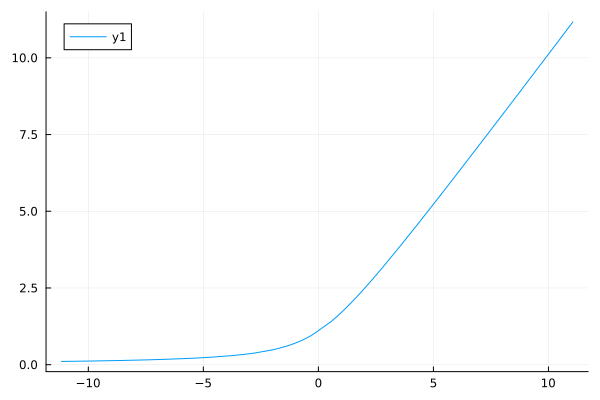

In [50]:
dims, theta, beta, w, h, _, _ = sequester_params(pp)
index = 1
xplot = sort!(rand(Uniform(-10, 10), 100))
xs = []
yplot = []
for i in eachindex(xplot)
    x = zeros(dims)
    x[index] = xplot[i]
    rho = theta * x + beta
    rhoindex = rho[index]
    push!(xs, rhoindex)
    push!(yplot, (rhoindex + sqrt(rhoindex^2 + 4*h)) / 2)
end

xys = Pair.(xs, yplot)
sort!(xys)
xs = getindex.(xys, 1)
ys = getindex.(xys, 2)
plot(xs, ys)